<a href="https://colab.research.google.com/github/nayoung718/essa_python_1/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_7%EC%9E%A5_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#핸즈온 7장 앙상블 학습과 랜덤 포레스트

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import package

import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

-대중의 지혜: 무작위 수천명의 답 모으면 전문가 답보다 나음-> 앙상블

-결정트리의 앙상블: 랜덤포레스트: 많은 선택을 받은 클래스를 예측으로

##7.1 투표기반 분류기

-각 분류기의 예측을 모아 가장 많이 선택된 클래스 예측-> 다수결: 직접 투표 분류기

-약한 학습기도 충분히 많고 다양하면 강한학습기됨

-큰수의 법칙: 많이 할수록 확률 가까워짐

-분류기들이 같은 종류의 오차를 만들기 쉬움-> 잘못된 클래스가 다수인 경우가 많고 앙상블 정확도 낮아짐 : 예측기 서로 독립적일 경우 성능 향상

In [2]:
#투표기반분류기

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC()

voting_clf=VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.95
SVC 0.95
VotingClassifier 0.95


투표기반 분류기가 다른 개별 분류기보다 성능 높음

-모든 분류기가 클래스 확률 예측할 수 있으면 개별 분류기의 예측을 평균내어 확률 가장 높은 클래스 예측 가능: 간접 투표

-> voting hard-> soft

##7.2 배깅과 페이스팅

-배깅: 훈련 셋에서 중복 허용해 샘플링하는 방식(한 예측기 위해 같은 훈련 샘플 여러번 샘플링 가능)

-페이스팅: 중복을 허용하지 않고 샘플링하는 방식

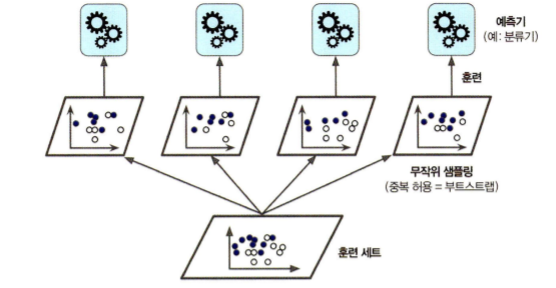

-수집함수: 분류-통계적 최빈값, 회귀-평균

-앙상블 결과는 원본 데이터셋에 하나의 예측기를 훈련시킬 떄와 비교해 편향 비슷, 분산 감소

###7.2.1 사이킷런의 배깅과 페이스팅

BaggingClassifier 이용: 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률 추정할수 있으면 직접투표대신 간접 투표방식 사용

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf=BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred=bag_clf.predict(X_test)

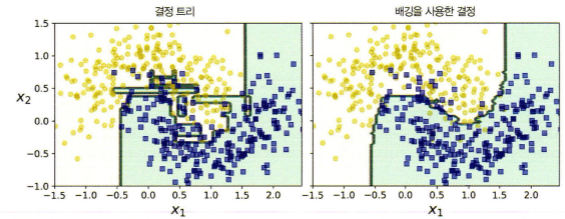

앙상블 예측이 결정트리 하나의 예측보다 일반화 잘됨, 앙상블 비슷한 편향서 더 작은 분산 만듦

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시켜 배깅이 페이스팅보다 편향 좀 더 높음

-> 다양성 추가: 예측기 상관관계 줄어듦, 앙상블 분산 감소

###7.2.2 obb 평가

배깅-> 어떤건 여러번 샘플링, 어떤건 선택x

baggingclassifier는 기본값으로 중복 허용해 훈련 세트 크기만큼 샘플 선택

예측기 훈련동안 obb 샘플 사용안하므로 별도 검증 세트 사용 안하고 oob 샘플 사용해 평가 가능, 앙상블 평가는 각 예측기의 oob 평가 평균하여 얻음

-> oob_score=true 지정시 훈련 끝나고 자동 oob 평가 수행

In [5]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [6]:
#정확도
y_pred=bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

1.0

In [7]:
#oob 샘플에 대한 결정 함수 값
bag_clf.oob_decision_function_

array([[0.77083333, 0.22916667],
       [1.        , 0.        ],
       [0.10752688, 0.89247312],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.00584795, 0.99415205],
       [0.        , 1.        ],
       [0.95530726, 0.04469274],
       [0.67027027, 0.32972973],
       [0.2202381 , 0.7797619 ],
       [0.96511628, 0.03488372],
       [0.03351955, 0.96648045],
       [1.        , 0.        ],
       [0.8877551 , 0.1122449 ],
       [0.53191489, 0.46808511],
       [0.8490566 , 0.1509434 ],
       [0.99459459, 0.00540541],
       [0.89010989, 0.10989011],
       [0.02197802, 0.97802198],
       [0.74056604, 0.25943396],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.73096447, 0.26903553],
       [0.93714286, 0.06285714],
       [1.        , 0.        ],
       [0.97765363, 0.02234637],
       [0.        , 1.        ],
       [0.27659574, 0.72340426],
       [0.04972376, 0.95027624],
       [0.        , 1.        ],
       [1.

##7.3 랜덤 패치와 랜덤 서브스페이스

baggingclassifier 특성 샘플링도 지원-> max_features, bootstrap_features로 조절

-> 각 예측기 무작위 선택 입력특성의 일부분으로 훈련됨 (고차원 데이터셋 유용)

-랜덤패치방식: 훈련 특성+샘플 모두 샘플링

-랜덤서브스페이스방식: 훈련 샘플 모두 사용, 특성 샘플링(더 다양 예측기, 편향 늘리는 대신 분산 낮춤)

##7.4 랜덤포레스트

-랜덤포레스트: 배깅 적용한 결정트리 앙상블 (max_samples: 훈련세트 크기)

-baggingclassifier에 decisiontreeclassifier 넣지 않고 결정트리에 최적화되어 사용하기 편한 randomforestclassifier 사용가능

In [11]:
#500개 트리로 이뤄진 랜덤포레스트 분류기를 여러 cpu코어에서 훈련시킴
from sklearn.ensemble import RandomForestClassifier

rnd_clf=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf=rnd_clf.predict(X_test)

randomforestclassifier는 decisiontreeclassifier 매개변수와 앙상블 자체 제어에 필요한 baggingclassifier의 매개변수 모두 가짐

랜덤포레스트 알고리즘: 무작위 선택 특성 후보 중 최적 특성 찾는 식으로 무작위성 더 주입 -> 트리 다양하게, 편향 손해보는 대신 분산 낮춰 더 휼륭한 모델 만들어

In [13]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(max_features="auto",max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

###7.4.1 엑스트라 트리

랜덤포레스트-무작위 특성 서브셋 만들어 분할에 사용

-익스트림 랜덤 트리: 엑스트라 트리: 극단적 무작위한 트리의 랜덤 포레스트: ExtraTreesClassifier


###7.4.2 특성 중요도

랜덤포레스트: 특성 상대적 중요도 측정 쉬움

-어떤 특성을 사용한 노드가 평균적 불순도 얼마나 감소시키는지 확인해 특성 중요도 축정

-특성마다 자동 점수 계산, 중요도 전체 합 1 되도록 결과값 정규화: feature_importances_

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08700556944709932
sepal width (cm) 0.02214351416181022
petal length (cm) 0.43707841094529787
petal width (cm) 0.4537725054457927


mnist 데이터셋 랜덤포레스트 분류기 훈련시키고 각 픽셀 중요도 그래프로 나타내면 다음과 같은 이미지 얻음

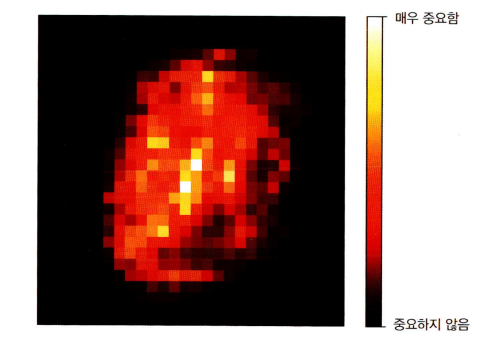

##7.5 부스팅

-부스팅: 약한 학습기 여러개 연결해 강한 학습기 만드는 앙상블 방법

-> 에이다부스트, 그레이디언트 부스팅


###7.5.1 에이다부스트

이전 예측기를 보완하는 새 예측기 만드는법: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임

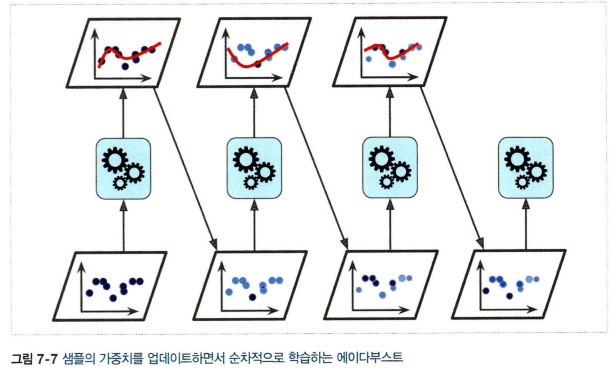

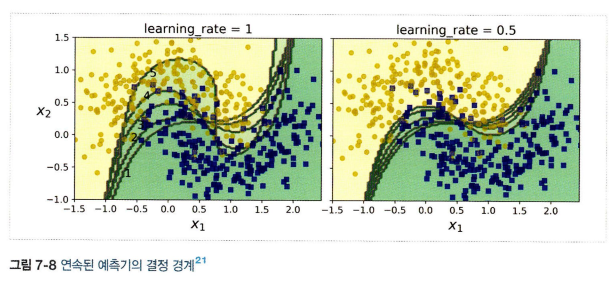

왼쪽 많은 샘플 잘못 분류해 샘플 가중치 높아짐, 오른쪽: 샘풀 더 정확히 예측

가중치가 적용된 훈련셋의 전반 정확도에 따라 예측기마다 다른 가중치 적용

-예측기의 가중치가 적용된 에러율
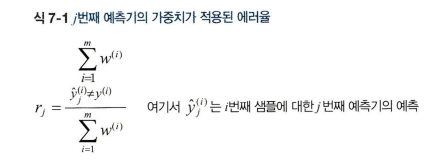

학습률 하이퍼파라미터 / 예측기 정확할수록 가중치 높아짐 / 무작위 예측-> 가중치 0에 가까움 / 그보다 나쁘면 가중치 음수

예측치 가중치
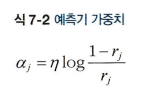

에이다부스트 알고리즘 샘플 가중치 업데이트 규칙

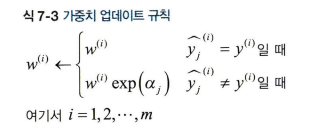

이 후 모든 샘플 가중치 정규화-> 새예측기가 업데이트된 가중치 사용해 훈련되고 전체 과정 반복-> 지정된 예측기 수 도달/완벽 예측기 완성시 중지

모든 예측기 예측 계산후 예측기 가중치 더해 결과 만들어-> 가중치 합이 가장 큰 클래스가 예측 결과

-SAMME 에이다부스트의 다중 클래스 버전 사용

-AdaBoostClassifier 사용해 결정 트리 기반 에이다부스트 분류기 훈련(결정트리 max_depth=1 사용: 결정 노드 하나와 리프노드 두개 이뤄진 트리)

In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf=AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=200,
    algorithm="SAMME.R",learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

###7.5.2 그레이디언트 부스팅

-반복마다 샘플 가중치 수정하는 대신 이전 예측기가 만든 잔여오차에 새로운 예측기 학습시킴

-그레이디언트 트리부스팅: 그레이디언트 부스티드 회귀트리

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [20]:
#첫번쨰 예측기에서 생긴 잔여오차에 두번째 regressor 훈련시킴
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

#두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련시킴
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

# 모든 트리의 예측을 더해 새로운 샘플에 대한 예측을 만들어
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

NameError: name 'X_new' is not defined

In [21]:
#트리가 앙상블에 추가될수록 앙상블 예측 좋아짐
#앙상블 만들어 그레디언트부스팅 사용해서

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

learning_rate가 각 트리의 기여 정도 조절

-> 낮으면 앙상블을 훈련셋에 학습시키기 위해 많은 트리 필요, 성능 좋아짐: 축소

-트리 너무 많으면 과대적합

-최적의 트리수 찾기: 조기 종료 기법 사용, staged_predict() 사용

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
               for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

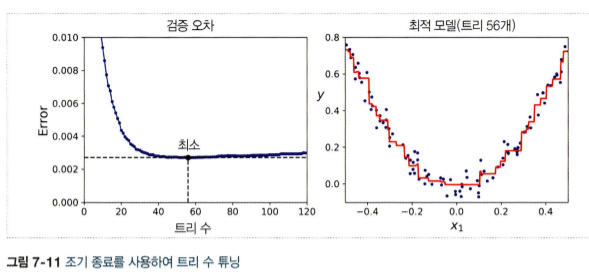

실제 훈련 중지 방법으로 조기 종료 구현 가능, warm_start=True: fit() 호출시 기존 트리 유지 훈련 추가하도록함

다음 코드 연속 다섯번 반복동안 검증 오차 향상 안되면 정지

In [23]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error= val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

각 트리 훈련시 사용할 훈련 샘플 비율 지정할 수 있는 subsample 매개변수도 지원

편향 상승시 분산 감소, 속도 높임 : 확률적 그레이디언트 부스팅

-> 최적화 그레이디언트 부스팅: xgboost

In [25]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [26]:
# 자동 조기 종료 기능 제공

xgb_reg.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.40813
[1]	validation_0-rmse:0.35796
[2]	validation_0-rmse:0.29989
[3]	validation_0-rmse:0.27727
[4]	validation_0-rmse:0.25858
[5]	validation_0-rmse:0.25339
[6]	validation_0-rmse:0.24244
[7]	validation_0-rmse:0.23484
[8]	validation_0-rmse:0.22930
[9]	validation_0-rmse:0.22789
[10]	validation_0-rmse:0.22697
[11]	validation_0-rmse:0.22411
[12]	validation_0-rmse:0.22311
[13]	validation_0-rmse:0.22089
[14]	validation_0-rmse:0.21906
[15]	validation_0-rmse:0.21921
[16]	validation_0-rmse:0.21938


##7.6 스태킹

-스태킹: 새로운 샘플에 회귀 작용 수행하는 앙상블

-블렌딩 예측기를 사용한 예측 취합

-홀드아웃세트 사용

-첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용, 첫번째 레이어의 예측기 사용해 두번째 세트에 대한 예측 만들어

-세개의 예측값 존재: 타깃값 그대로사용, 예측값 입력 특성으로 사용하는 새 훈련셋 만들어 : 블렌더가 새 훈련셋으로 훈련됨 : 첫번째 레이어의 예측 갖고 타깃값 예측하도록 학습됨

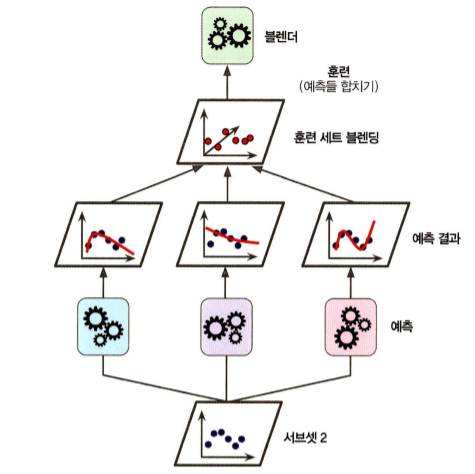

블렌더 여러개 훈련 시키기 가능-> 블렌더만의 레이어 만들어짐

훈련 셋 세개의 서브셋으로 나눔: 첫번째 레이어 훈련에 사용, 두번째 레이어 훈련에 사용, 세번째 레이어 훈련셋 만드는데 사용

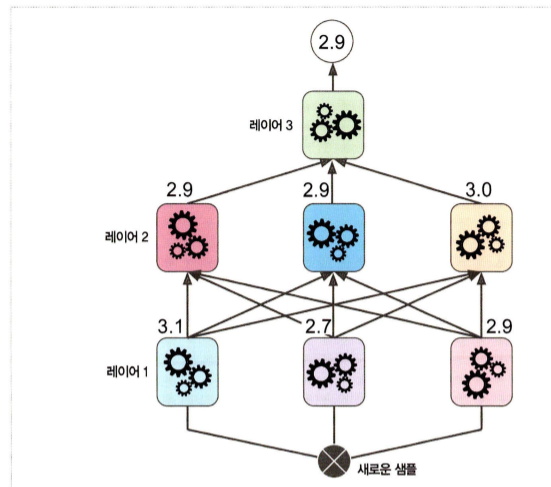

-> 사이킷런 스태킹 직접 지원 안함